In [ ]:
# -*- coding: utf-8 -*-
import argparse
import os
import pickle as pkl
import random

import numpy as np
import torch
# import torch.distributed
import wandb
from ase.units import GPa

from mattersim.datasets.utils.build import build_dataloader
from mattersim.forcefield.m3gnet.scaling import AtomScaling
from mattersim.forcefield.potential import Potential
from mattersim.utils.atoms_utils import AtomsAdaptor
from mattersim.utils.logger_utils import get_logger

from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import pandas as pd

/global/cfs/projectdirs/m4555/Jun/conda_envs/mattersim-LR/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/global/cfs/projectdirs/m4555/Jun/conda_envs/mattersim-LR/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadat

2025-11-03 20:56:46.979 | INFO     | mattersim.forcefield.potential:from_checkpoint:935 - Loading the model from ./results/last_model.pth
2025-11-03 20:58:25.216 | INFO     | mattersim.forcefield.potential:from_checkpoint:935 - Loading the model from ./results/best_model.pth
2025-11-03 20:59:30.580 | INFO     | mattersim.forcefield.potential:from_checkpoint:935 - Loading the model from ./results/last_model.pth


In [4]:
atoms_val = AtomsAdaptor.from_file(filename="../../data/benchmarks/val_water_1593_eVAng.xyz")
energies = []
forces = [] 
for atoms in atoms_val:
    energies.append(atoms.get_potential_energy() / len(atoms)) 
    forces.append(atoms.get_forces())

print(f"Processed {len(atoms_val)} validation data")

val_dataloader = build_dataloader(
    atoms_val,
    energies,
    forces,
    pin_memory=True,
    is_distributed=False,
    shuffle=False,
    batch_size=16
)

potential = Potential.from_checkpoint(
    load_path="./results/last_model.pth",
    load_training_state=False,
    long_range=True
)

predicted_energies, predicted_forces, _, charges, total_charges = potential.predict_properties(
    val_dataloader,
    include_forces=True,
    include_stresses=False
)

predicted_energies = np.array(predicted_energies) / len(atoms)

true_energies, true_forces = energies, forces

Processed 160 validation data
total_charges:	 tensor([-0.0038, -0.0007,  0.0010,  0.0008,  0.0003, -0.0009, -0.0008, -0.0030,
         0.0022, -0.0018,  0.0055, -0.0012, -0.0009, -0.0018,  0.0013,  0.0030],
       device='cuda:0', grad_fn=<ScatterAddBackward0>)
total_charges:	 tensor([ 0.0019, -0.0041,  0.0044, -0.0012, -0.0032,  0.0027,  0.0070, -0.0016,
         0.0016, -0.0035,  0.0001,  0.0011, -0.0009,  0.0017, -0.0013, -0.0106],
       device='cuda:0', grad_fn=<ScatterAddBackward0>)
total_charges:	 tensor([ 7.8577e-05, -1.6674e-04, -6.0586e-03,  1.2033e-02, -1.4941e-03,
        -6.2753e-05, -1.6101e-04,  6.5857e-03, -3.8005e-03,  1.0775e-03,
        -1.9402e-03,  3.0630e-04, -8.7045e-03, -8.4530e-04, -3.9721e-03,
         6.7000e-03], device='cuda:0', grad_fn=<ScatterAddBackward0>)
total_charges:	 tensor([-2.1528e-03,  3.0805e-03, -2.6573e-03,  2.4389e-03, -1.6627e-04,
        -2.1126e-03,  7.0557e-05,  1.1812e-03,  2.2022e-03,  1.1965e-02,
        -2.4117e-03,  7.7160e-04,  1.60

In [5]:
element_list = []
for i in range(len(atoms_val)):
    element_list += atoms_val[i].get_chemical_symbols()

In [ ]:
df = pd.DataFrame({"Atoms": element_list, "Predicted Charges": charges})
df

,Atoms,Predicted Charges
0,O,0.003123
1,H,-0.002111
2,H,-0.001974
3,O,0.004425
4,H,-0.001917
...,...,...
30715,H,-0.001753
30716,H,-0.001901
30717,O,0.004207
30718,H,-0.002051


0.0005508783357072389


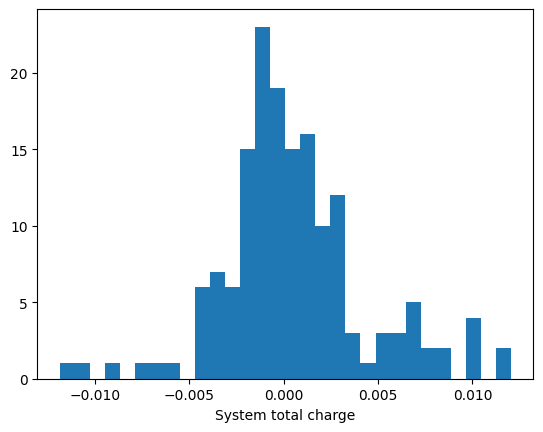

In [8]:
count = 0
system_charge = []
for i in atoms_val:
    system_charge.append(sum(df["Predicted Charges"].iloc[count:count+len(i)]))
    count += len(i)

plt.hist(np.array(system_charge), bins=30)
plt.xlabel("System total charge")
print(np.array(system_charge).mean())

8.607473995425608e-06


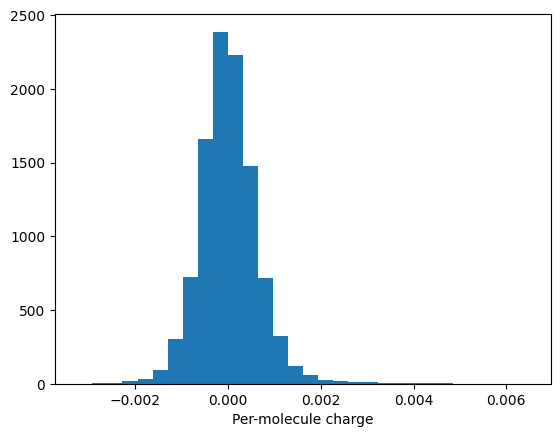

In [9]:
molecule_charge = []
for i in range(0, len(df), 3):
    molecule_charge.append(sum(df["Predicted Charges"].iloc[i:i+3]))

plt.hist(np.array(molecule_charge), bins=30)
plt.xlabel("Per-molecule charge")

print(np.array(molecule_charge).mean())

Text(0.5, 0, 'Average charge')

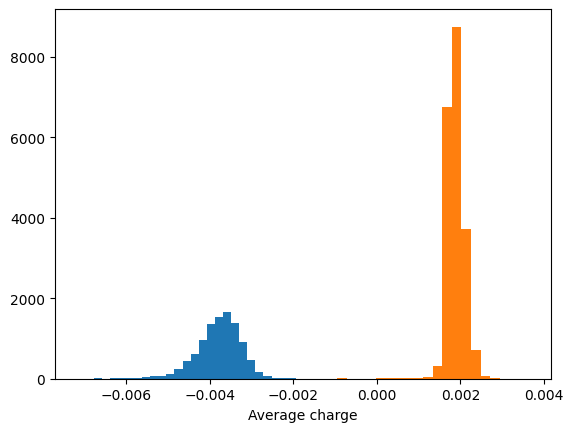

In [29]:
plt.hist(-df[df["Atoms"] == "O"]["Predicted Charges"], bins=30)
plt.hist(-df[df["Atoms"] == "H"]["Predicted Charges"], bins=30)
plt.xlabel("Average charge")